### Import required libraries

In [1]:
from dotenv import load_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import ChatPromptTemplate
from typing import Literal
import re
from pydantic import BaseModel,Field
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.messages import HumanMessage, AIMessage


USER_AGENT environment variable not set, consider setting it to identify your requests.


### Load the environmental variables

In [2]:
load_dotenv()

True

### Load The data

In [3]:
urls = [
    "https://www.webmd.com/epilepsy/default.htm",
    "https://www.webmd.com/arthritis/default.htm",
    "https://www.webmd.com/osteoporosis/default.htm",
    "https://www.webmd.com/a-to-z-guides/malaria",
    "https://www.webmd.com/diabetes/type-1-diabetes",
    "https://www.webmd.com/diabetes/type-2-diabetes",
    "https://www.webmd.com/migraines-headaches/migraines-headaches-migraines",
    "https://www.webmd.com/asthma/guide/asthma",
    "https://www.webmd.com/heart-disease/heart-disease-default",
    "https://www.webmd.com/cancer/default.htm",
    "https://www.webmd.com/skin-problems-and-treatments/eczema/default.htm",
    "https://www.webmd.com/allergies/default.htm",
    "https://www.webmd.com/cold-and-flu/cold-guide/default.htm",
    "https://www.webmd.com/cold-and-flu/flu-guide/default.htm",
    "https://www.webmd.com/hepatitis/hepatitis-c/default.htm",
    "https://www.webmd.com/hiv-aids/default.htm",
    "https://www.webmd.com/mental-health/addiction/default.htm",
    "https://www.webmd.com/depression/default.htm",
    "https://www.webmd.com/mental-health/anxiety-disorders/default.htm",
    "https://www.webmd.com/alzheimers/default.htm",
    "https://www.webmd.com/parkinsons-disease/default.htm",
    "https://www.webmd.com/stroke/default.htm",
    "https://www.webmd.com/pain-management/default.htm",
    "https://www.webmd.com/sexual-conditions/default.htm",
]

loader = WebBaseLoader(urls)
docs = loader.load()
docs


[Document(metadata={'source': 'https://www.webmd.com/epilepsy/default.htm', 'title': 'Epilepsy Center: Symptoms, Seizures, Treatments, Causes, and Tests', 'description': 'Epilepsy is diagnosed in 125,000 Americans each year. Find in-depth information here on such issues as seizures, symptoms, and treatments.', 'language': 'en'}, page_content="\n\n\nEpilepsy Center: Symptoms, Seizures, Treatments, Causes, and Tests\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n Skip to main content  Home Conditions  Back Conditions View All ADD/ADHDAllergiesArthritisAtrial fibrillationBreast CancerCancerCrohn's DiseaseDepressionDiabetesDVTEczemaEye HealthHeart DiseaseHIV & AIDSLung DiseaseLupusMental HealthMultiple SclerosisMigrainePain ManagementPsoriasisPsoriatic ArthritisRheumatoid ArthritisSexual ConditionsSkin ProblemsSleep DisordersUlcerative Colitis View All Drugs & Supplements  Back Drugs & SupplementsDrugsSupplementsPill IdentifierInteraction Check

### Create Chunks

In [5]:
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks=splitter.split_documents(docs)
chunks

[Document(metadata={'source': 'https://www.webmd.com/epilepsy/default.htm', 'title': 'Epilepsy Center: Symptoms, Seizures, Treatments, Causes, and Tests', 'description': 'Epilepsy is diagnosed in 125,000 Americans each year. Find in-depth information here on such issues as seizures, symptoms, and treatments.', 'language': 'en'}, page_content='Epilepsy Center: Symptoms, Seizures, Treatments, Causes, and Tests'),
 Document(metadata={'source': 'https://www.webmd.com/epilepsy/default.htm', 'title': 'Epilepsy Center: Symptoms, Seizures, Treatments, Causes, and Tests', 'description': 'Epilepsy is diagnosed in 125,000 Americans each year. Find in-depth information here on such issues as seizures, symptoms, and treatments.', 'language': 'en'}, page_content="Skip to main content  Home Conditions  Back Conditions View All ADD/ADHDAllergiesArthritisAtrial fibrillationBreast CancerCancerCrohn's DiseaseDepressionDiabetesDVTEczemaEye HealthHeart DiseaseHIV & AIDSLung DiseaseLupusMental HealthMultipl

### Load Embedding model and LLM

In [6]:
embedding_fun = HuggingFaceEmbeddings()
embedding_fun

d:\AI\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HuggingFaceEmbeddings(model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [7]:
llm = ChatGroq(model="Llama3-70b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022E0692F150>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022E07BD7CD0>, model_name='Llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

### Create vector store

In [8]:
vectordb = Chroma.from_documents(documents=chunks, embedding=embedding_fun)
vectordb

### Create retriever

In [9]:
retriever = vectordb.as_retriever()
retriever

VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x0000022E07BF5250>, search_kwargs={})

### Vector Search

In [10]:
def retrieve_docs(query:str):
    context = retriever.get_relevant_documents(query)
    return context

### Web Search

In [11]:
web_search_tool = TavilySearchResults()
def web_search(query:str):
    results = web_search_tool.invoke(query)
    return results

C:\Users\Hp\AppData\Local\Temp\ipykernel_6504\3510001923.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults()


### define the tools

In [12]:
class VectorStore(BaseModel):
    """
    A vectorstore contains information about various medical conditions 
    such as malaria, type 1 and type 2 diabetes, migraines, asthma, heart disease, 
    cancer, skin problems (eczema), allergies, cold and flu, hepatitis, HIV/AIDS, 
    mental health disorders (depression, anxiety, addiction), Alzheimer's, 
    Parkinson's, epilepsy, arthritis, osteoporosis, stroke, pain management, 
    and sexual health, among others.
    """
    query: str


class SearchEngine(BaseModel):
    """
    A search engine for retrieving additional medical information 
    from the web beyond what is stored in the vector database.
    """
    query: str


### Binding llm with tools

In [13]:
tools=[VectorStore, SearchEngine]
llm_with_tools= llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000022E0692F150>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000022E07BD7CD0>, model_name='Llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'VectorStore', 'description': "A vectorstore contains information about various medical conditions \nsuch as malaria, type 1 and type 2 diabetes, migraines, asthma, heart disease, \ncancer, skin problems (eczema), allergies, cold and flu, hepatitis, HIV/AIDS, \nmental health disorders (depression, anxiety, addiction), Alzheimer's, \nParkinson's, epilepsy, arthritis, osteoporosis, stroke, pain management, \nand sexual health, among others.", 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'SearchEngine', 'description': 'A search engine for ret

### Router

In [14]:
router_prompt_template = (
    "You are an expert in routing user queries to either VectorStore or SearchEngine.\n"
    "Use VectorStore for queries related to the following medical conditions:\n"
    "malaria, type 1 diabetes, type 2 diabetes, migraines, asthma, heart disease, "
    "cancer, skin problems (eczema), allergies, cold and flu, hepatitis, HIV/AIDS, "
    "mental health disorders (depression, anxiety, addiction), Alzheimer's, Parkinson's, "
    "epilepsy, arthritis, osteoporosis, stroke, pain management, and sexual health.\n"
    "Use SearchEngine for all other medical queries not covered by the VectorStore.\n"
    "If a query is not medically-related, you must output 'Not medically-related' "
    "and do not try to use any tool.\n\n"
    "query: {query}"
)

router_prompt = ChatPromptTemplate.from_template(router_prompt_template)
router_chain = router_prompt | llm_with_tools




### Testing the router for all types of queries

In [15]:
query = "What are symptoms of migraine?"
response = router_chain.invoke(query)
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '06dp79vnq', 'function': {'arguments': '{"query":"migraines"}', 'name': 'VectorStore'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1226, 'total_tokens': 1271, 'completion_time': 0.097407557, 'prompt_time': 0.097214988, 'queue_time': 0.219928216, 'total_time': 0.194622545}, 'model_name': 'Llama3-70b-8192', 'system_fingerprint': 'fp_de9fa14705', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--836f9044-0fa7-48cc-a389-83bf374fb74b-0', tool_calls=[{'name': 'VectorStore', 'args': {'query': 'migraines'}, 'id': '06dp79vnq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1226, 'output_tokens': 45, 'total_tokens': 1271})

In [16]:
query = "What are risk factors of asthma?"
response = router_chain.invoke(query)
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x2ta6f1zs', 'function': {'arguments': '{"query":"What are risk factors of asthma?"}', 'name': 'VectorStore'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 1227, 'total_tokens': 1276, 'completion_time': 0.113862109, 'prompt_time': 0.096797993, 'queue_time': 0.220191466, 'total_time': 0.210660102}, 'model_name': 'Llama3-70b-8192', 'system_fingerprint': 'fp_de9fa14705', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f917ed19-9827-4203-a59a-fec782773eff-0', tool_calls=[{'name': 'VectorStore', 'args': {'query': 'What are risk factors of asthma?'}, 'id': 'x2ta6f1zs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1227, 'output_tokens': 49, 'total_tokens': 1276})

In [17]:
query="What is the latest COVID-19 variant in 2025?"
response=router_chain.invoke({
    "query":query
})
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hv8z15swt', 'function': {'arguments': '{"query":"What is the latest COVID-19 variant in 2025?"}', 'name': 'SearchEngine'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 1233, 'total_tokens': 1288, 'completion_time': 0.109451954, 'prompt_time': 0.097210868, 'queue_time': 0.270141881, 'total_time': 0.206662822}, 'model_name': 'Llama3-70b-8192', 'system_fingerprint': 'fp_de9fa14705', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c0197bf0-e593-4fad-a42e-783eac857739-0', tool_calls=[{'name': 'SearchEngine', 'args': {'query': 'What is the latest COVID-19 variant in 2025?'}, 'id': 'hv8z15swt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1233, 'output_tokens': 55, 'total_tokens': 1288})

In [18]:
query="What is MongoDB?"
response=router_chain.invoke({
    "query":query
})
response

AIMessage(content='Not medically-related', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 1224, 'total_tokens': 1228, 'completion_time': 0.008900609, 'prompt_time': 0.096825002, 'queue_time': 0.220068026, 'total_time': 0.105725611}, 'model_name': 'Llama3-70b-8192', 'system_fingerprint': 'fp_de9fa14705', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8a7c0fc4-3733-4b94-91ce-467930c2ba7f-0', usage_metadata={'input_tokens': 1224, 'output_tokens': 4, 'total_tokens': 1228})

### Fallback Chain

In [19]:
fallback_prompt_template="""You are a medical expert who is responsible for responding to medical related queries.
If a query is not medically-related then politely acknowledge your limitations and provide concise responses to only medical related queries.
Current conversations:\n\n{chat_history}
Query:{query}
"""
fallback_prompt = ChatPromptTemplate.from_template(fallback_prompt_template)
fallback_chain=(
    {
        "query":itemgetter("query"),
        "chat_history":lambda x: "\n".join(
        [
            (
                f"human:{msg.context}"
                if isinstance(msg,HumanMessage)
                else f"AI:{msg.context}"
            )
            for msg in x["chat_history"]
        ]
        )

    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)


### Testing Fallback Chain

In [20]:
query="What is mongoDB?"
response = fallback_chain.invoke({
    "query":query, 
    "chat_history":[]
})
Markdown(response)

I'm happy to help! However, I must admit that I'm a medical expert, and MongoDB is not a medical-related topic. MongoDB is a NoSQL database program used for storing and managing large amounts of data, but it's outside my area of expertise.

If you have any medical-related questions or concerns, I'd be more than happy to help.

### Grader 

In [23]:
from langchain_core.pydantic_v1 import validator
class Grader(BaseModel):
    """format used to assign binary score to the retrieved documents based on the relevancy to the query """
    grade:Literal["relevant", "irrelevant"]=Field(
        ...,
        description="Use to grade the relevancy of the retrieved docuemnts"
        "If the retrieved documents are relevant to the query give it a score 'relevant' else 'irrelevant'"

    )

grader_prompt_template=""""You are a grader tasked with assessing the relevance of a given context to a query. 
    If the context is relevant to the query, score it as "relevant". Otherwise, give "irrelevant".
    Do not answer the actual answer, just provide the grade in JSON format with "grade" as the key, without any additional explanation."
    """
grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_prompt_template),
        ("human","query:{query}\ncontext:{context}")
    ]
)
grader_llm = llm.with_structured_output(Grader,method="json_mode")
grader_chain = grader_prompt|grader_llm


### Testing the grader

In [24]:
query="What is symptoms of asthma?"
context = retrieve_docs(query)
response=grader_chain.invoke({
    "query":query,
    "context":context
})
response

C:\Users\Hp\AppData\Local\Temp\ipykernel_6504\2734433046.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  context = retriever.get_relevant_documents(query)


Grader(grade='relevant')

In [25]:
query="What is latest COVID-19 news of 2025?"
context = web_search(query)
response=grader_chain.invoke({
    "query":query,
    "context":context
})
response

Grader(grade='relevant')

In [26]:
query="What is latest COVID-19 news of 2025?"
context = retrieve_docs(query)
response=grader_chain.invoke({
    "query":query,
    "context":context
})
response

Grader(grade='irrelevant')

### RAG Pipeline

In [27]:
rag_prompt_template=("You are a helpful assistant who has to answer the query below based on the context provided."
                     "context:{context}\n\n"
                     "query:{query}")
rag_prompt = ChatPromptTemplate.from_template(rag_prompt_template)
rag_chain = rag_prompt|llm|StrOutputParser()

### Testig RAG Pipeline

In [28]:
query="what are symptoms of osteoporosis?"
context=retrieve_docs(query)
response=rag_chain.invoke({
    "query":query,
    "context":context
})
response
Markdown(response)

The provided context doesn't explicitly mention the symptoms of osteoporosis. However, it does provide an overview of osteoporosis, its causes, diagnosis, treatment, and prevention. It also mentions that osteoporosis weakens bones and increases the risk of unexpected fractures, and that serious consequences can occur with some fractures.

In general, common symptoms of osteoporosis include:

* Back pain or stooped posture due to vertebral compression fractures
* Loss of height over time
* Fractures or breaks in the bones, especially in the hips, spine, or wrists
* Weakness or fragility of the bones
* Decreased mobility or ability to perform daily activities

It's important to note that osteoporosis can be asymptomatic in its early stages, and some people may not experience any symptoms until they suffer a fracture. If you're concerned about osteoporosis or its symptoms, it's best to consult a healthcare professional for proper diagnosis and treatment.

### Hallucination Check

In [30]:
class HallucinationGrader(BaseModel):
    "Binary score for hallucination check in llm's response"

    grade: Literal["yes", "no"] = Field(
        ..., description="'yes' if the llm's reponse is hallucinated otherwise 'no'"
    )

hallucination_prompt_template = (
    "You are a grader assessing whether a response from an llm is based on a given context.\n"
    "If the llm's response is not based on the given context give a score of 'yes' meaning it's a hallucination"
    "otherwise give 'no'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_prompt_template),
        ("human","response:{response}\ncontext:{context}")
    ]
)
hallucination_chain = (
    {
        "response":itemgetter("response"),
        "context":lambda x: "\n\n".join(
            [
                c.page_content
                for c in x["context"]
            ] 
            
        )

    }
    |
    hallucination_prompt|llm.with_structured_output(HallucinationGrader, method="json_mode")
)

### Testing Hallucination Grader

In [31]:
response = """Based on the context, malaria is transmitted through the bite of an infected Anopheles mosquito. 
The parasites travel to the liver where they mature and then infect red blood cells."""
query="How is malaria transmitted?"
context = retrieve_docs(query)
response = hallucination_chain.invoke({
    "response":response,
    "context":context
})
response

HallucinationGrader(grade='no')

In [32]:
response = """Malaria can be transmitted through contaminated water and food, similar to cholera. 
People can also get malaria by shaking hands with infected individuals."""
query="How is malaria transmitted?"
context = retrieve_docs(query)
response = hallucination_chain.invoke({
    "response":response,
    "context":context
})
response

HallucinationGrader(grade='yes')

### Answer Grader

In [33]:
class AnswerGrader(BaseModel):
    "Binary score for an answer check based on a query."

    grade: Literal["yes", "no"] = Field(
        ...,
        description="'yes' if the provided answer is an actual answer to the query otherwise 'no'",
    )

answer_grader_system_prompt_template = (
    "You are a grader assessing whether a provided answer is in fact an answer to the given query.\n"
    "If the provided answer does not answer the query give a score of 'no' otherwise give 'yes'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt_template),
        ("human", "query: {query}\n\nanswer: {response}")
    ]
)

answer_chain = answer_prompt | llm.with_structured_output(
    AnswerGrader, method="json_mode"
)

### Testing Answer Grader

In [35]:
query="what are symnptoms of malaria?"
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = answer_chain.invoke(
    {
        "query":query,
        "response":response
    }
)
response

AnswerGrader(grade='yes')

In [38]:
query="how is malaria transmitted?"
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = answer_chain.invoke(
    {
        "query":query,
        "response":response
    }
)
response

AnswerGrader(grade='no')

### Creating Agentic Flow


In [39]:
#define the agent state
from typing import TypedDict, List
from langchain_core.messages import BaseMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
    query:str
    response:str
    chat_history:list[BaseMessage]
    context :list[Document]


In [40]:
#define router node
def question_router_node(state:AgentState):
    query = state['query']
    try:
        response = router_chain.invoke({
            "query":query
        })
    except Exception:
        return "llm_fallback"
    
    if "tool_calls" not in response.additional_kwargs:
        print("NO TOOL CALLED")
        return "llm_fallback"
    if len(response.additional_kwargs["tool_calls"])==0:
        raise "Router can't decide route"
    
    if "VectorStore" in response.additional_kwargs["tool_calls"][0]["function"]["name"]:
        print("ROUTING TO VECTOR STORE")
        return "VectorStore"
    elif "SearchEngine" in response.additional_kwargs["tool_calls"][0]["function"]["name"]:
        print("ROUTING TO SEARCH ENGINE")
        return "SearchEngine"

In [41]:
def fallback_node(state:AgentState):
    query=state['query']
    chat_history=state['chat_history']
    response = fallback_chain.invoke({
        "query":query,
        "chat_history":chat_history
    })
    return {"response": response}

In [42]:
def retrieve_node(state:AgentState):
    query=state['query']
    context = retriever.invoke(query)
    return {"context":context}

In [43]:
def web_search_node(state:AgentState):
    query=state['query']
    results = web_search(query)
    documents = [
        Document(
            page_content=doc["content"], metadata={
                "source":doc["url"]
            }
        ) for doc in results
    ]
    
    return {"context":documents}

In [44]:
def filter_docs_node(state:AgentState):
    query=state['query']
    documents=state['context']
    filtered_docs=[]
    for i, doc in enumerate(documents, start=1):
        grader_response = grader_chain.invoke({
            "query":query,
            "context":doc
        })
        if grader_response.grade=="relevant":
            print(f"RETRIEVED DOCUMENT {i} IS RELEVANT")
            filtered_docs.append(doc)
        else:
            print(f"RETRIEVED DOCUMENT {i} IS RELEVANT")
    
    return {"context":filtered_docs}
        

In [45]:
def should_generate(state:AgentState):
    filtered_documents = state['context']
    if not filtered_documents:
        print("ALL DOCUMENTS RETRIEVED ARE IRRELEVANT")
        return "SearchEngine"
    else:
        print("SOME DOCUMENTS RETRIEVED ARE RELEVANT")
        return "generate"

In [46]:
def rag_node(state:AgentState):
    query=state['query']
    context = state['context']
    response = rag_chain.invoke({
        "query":query,
        "context":context
    })
    return {"response":response}

In [47]:
def hallucination_and_answer_relevance_node(state:AgentState):
    query=state['query']
    context = state['context']
    response=state['response']

    hallucination_grade=hallucination_chain.invoke({
        "response":response,
        "context":context
    })
    if hallucination_grade.grade=="no":
        print("NOT HALLUCINATED")
        answer_relevance_grade=answer_chain.invoke({"query":query, "response":response})
        if answer_relevance_grade.grade=="yes":
            print("ANSWER IS RELEVANT TO THE QUERY")
            return "useful"
        else:
            print("ANSWER IS NOT RELEVANT TO THE QUERY")
            return "not useful"
    print("HALLUCINATED")
    return "generate"
    

### Let's create the graph

In [48]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState)
graph.add_node("VectorStore",retrieve_node)
graph.add_node("SearchEngine", web_search_node)
graph.add_node("fallback",fallback_node)
graph.add_node("filter_docs",filter_docs_node)
graph.add_node("rag",rag_node)

graph.set_conditional_entry_point(question_router_node,{
    "llm_fallback": "fallback",
    "VectorStore":"VectorStore",
    "SearchEngine": "SearchEngine"
})
graph.add_edge("VectorStore", "filter_docs")
graph.add_edge("SearchEngine", "filter_docs")
graph.add_conditional_edges("filter_docs",should_generate,{
    "SearchEngine":"SearchEngine",
    "generate":"rag"
})
graph.add_conditional_edges("rag",hallucination_and_answer_relevance_node,{"generate":"rag","useful":END, "not useful":"SearchEngine"
})
graph.add_edge("fallback", END)

In [49]:
graph = graph.compile()

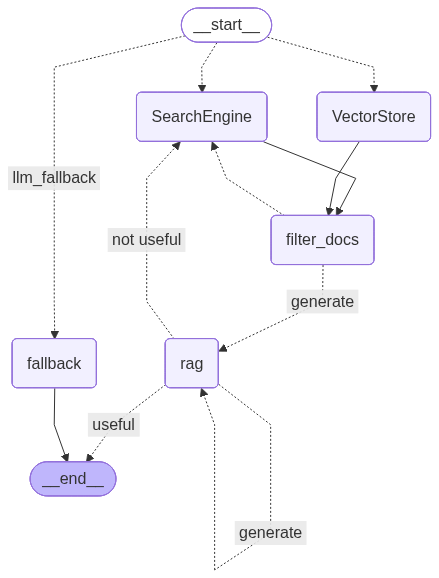

In [50]:
from IPython.display import display, Image
try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))

except Exception:
    pass

### Testing


In [51]:
for token in graph.stream({"query": "What are the risk factors of migraines", "chat_history": []}):
    print(token, end="", flush=True)

ROUTING TO VECTOR STORE
{'VectorStore': {'context': [Document(metadata={'title': 'Migraine: Symptoms, Causes, and Treatment', 'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, &amp; treatment of migraines.', 'language': 'en', 'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines'}, page_content="a history of these types of headaches, you have a 50% chance of getting them. If both parents have them, the risk jumps to 75%.Other medical conditions.\xa0Depression,\xa0anxiety,\xa0bipolar disorder,\xa0sleep disorders, and\xa0epilepsy\xa0can raise your odds.Migraine TriggersSome things that may trigger an attack\xa0include:Hormone changes.\xa0You maynotice that you have headaches around your period, while you're\xa0pregnant, or when you're\xa0ovulating. Symptoms may also be tied to menopause,\xa0hormonal birth control"), Document(metadata={'

In [52]:
for token in graph.stream({"query": "What are databases?", "chat_history": []}):
    print(token, end="", flush=True)

NO TOOL CALLED
{'fallback': {'response': "I'm a medical expert, and I'm not equipped to provide information on non-medical topics such as databases. My expertise lies in providing medical advice and information. If you have a medical-related query, I'd be happy to help. Otherwise, I recommend seeking guidance from a specialist in the relevant field."}}

In [54]:
for token in graph.stream({"query": "What is latest covid 19 news as of 2025?", "chat_history": []}):
    print(token, end="", flush=True)

ROUTING TO SEARCH ENGINE
{'SearchEngine': {'context': [Document(metadata={'source': 'https://data.who.int/dashboards/covid19/summary'}, page_content='In the 28-day period from 07 July 2025 to 03 August 2025, 83 countries across five WHO regions reported new COVID-19 cases. During this 28-day period, a total of 56,174 new cases were reported, which is a decrease compared to the 184,020 new cases reported from 92 countries in the previous 28-day period (Table 2). Overall, 28 countries from Africa, the Americas, Europe, and South-East Asia showed an increase in new cases of over 10%.\n\nCountry level details are available in | Cases section [...] In the 28-day period from 07 July 2025 to 03 August 2025, 42 countries across five WHO regions reported new COVID-19 deaths. During this 28-day period, a total of 885 new deaths were reported, which is a decrease compared to the 1,132 new deaths reported from 43 countries in the previous 28-day period (Table 2). Ten countries from the Americas, E